Imputation strategies

In [ ]:
# ==========================================
# Final Sensitivity Analysis with Tuned Models
# ==========================================

!pip install imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

# ==========================================
# Load dataset
# ==========================================
df = pd.read_csv("/content/drive/MyDrive/thesis/dataset_dementia (1) (1).csv")  # <-- change filename

target_col = [c for c in df.columns if "dementia" in c.lower()][0]
X = df.drop(columns=[target_col])
y = df[target_col]

if y.dtype == "object" or y.nunique() > 2:
    le = LabelEncoder()
    y = le.fit_transform(y.astype(str))

mask = y.notna()
X, y = X.loc[mask], y.loc[mask]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==========================================
# Gaussian Noise Augmentation (Train only)
# ==========================================
cognitive_cols = ["Executive Function", "Processing Speed", "Global Score"]
for col in cognitive_cols:
    if col in X_train_raw.columns:
        noise = np.random.normal(0, 0.01, size=X_train_raw[col].shape)
        X_train_raw[col] = X_train_raw[col] + noise

# ==========================================
# Imputation Strategies
# ==========================================
numeric_cols = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train_raw.columns if c not in numeric_cols]

strategies = {
    "MeanMode": (
        SimpleImputer(strategy="mean"),
        SimpleImputer(strategy="most_frequent")
    ),
    "KNN": (
        KNNImputer(n_neighbors=5),
        SimpleImputer(strategy="most_frequent")
    ),
    "MICE": (
        IterativeImputer(random_state=42, max_iter=10),
        SimpleImputer(strategy="most_frequent")
    )
}

# ==========================================
# Models + Parameter Grids
# ==========================================
models_dict = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(max_iter=500, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

param_grids = {
    "RandomForest": {
        "n_estimators": [200, 300],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "class_weight": [None, "balanced"]
    },
    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5]
    },
    "MLP": {
        "hidden_layer_sizes": [(64,32,16), (128,64), (256,128,64)],
        "activation": ["relu", "tanh"],
        "alpha": [0.0001, 0.001],
        "learning_rate_init": [0.001, 0.01]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", 0.01],
        "kernel": ["rbf", "linear"]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 11],
        "weights": ["uniform", "distance"]
    }
}

# ==========================================
# Run Sensitivity Analysis with Tuning
# ==========================================
results = []

for strat_name, (num_imputer, cat_imputer) in strategies.items():
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", num_imputer), ("scaler", StandardScaler())]), numeric_cols),
            ("cat", Pipeline([("imputer", cat_imputer), ("onehot", OneHotEncoder(handle_unknown="ignore"))]), categorical_cols)
        ]
    )

    X_train = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)

    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

    for model_name, model in models_dict.items():
        if model_name in param_grids:
            gs = GridSearchCV(model, param_grids[model_name], cv=3, scoring="accuracy", n_jobs=-1, verbose=0)
            gs.fit(X_train_bal, y_train_bal)
            best_model = gs.best_estimator_
        else:
            best_model = model.fit(X_train_bal, y_train_bal)

        y_pred = best_model.predict(X_test)

        results.append({
            "Imputation": strat_name,
            "Model": model_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1": f1_score(y_test, y_pred, zero_division=0)
        })

# ==========================================
# Save + Display Results
# ==========================================
results_df = pd.DataFrame(results)
print("\n=== Final Tuned Sensitivity Analysis Results (Table X Updated) ===\n")
print(results_df.pivot(index="Model", columns="Imputation", values="Accuracy").round(3))
print("\nFull Results:\n", results_df)

results_df.to_csv("sensitivity_analysis_tuned.csv", index=False)



=== Final Tuned Sensitivity Analysis Results (Table X Updated) ===

Imputation          KNN   MICE  MeanMode
Model                                   
GaussianNB        0.721  0.721     0.713
GradientBoosting  0.956  0.950     0.950
KNN               0.881  0.856     0.865
MLP               0.914  0.912     0.934
RandomForest      0.936  0.939     0.939
SVM               0.884  0.876     0.870

Full Results:
    Imputation             Model  Accuracy  Precision  Recall        F1
0    MeanMode      RandomForest  0.939227   0.250000  0.1875  0.214286
1    MeanMode               SVM  0.870166   0.121951  0.3125  0.175439
2    MeanMode               KNN  0.864641   0.148936  0.4375  0.222222
3    MeanMode        GaussianNB  0.712707   0.092593  0.6250  0.161290
4    MeanMode               MLP  0.933702   0.250000  0.2500  0.250000
5    MeanMode  GradientBoosting  0.950276   0.416667  0.3125  0.357143
6         KNN      RandomForest  0.936464   0.230769  0.1875  0.206897
7         KNN      

95% CI

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

from statsmodels.stats.contingency_tables import mcnemar

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

# Drop rows with missing target
df = df.dropna(subset=["dementia"])

X = df.drop("dementia", axis=1)
y = df["dementia"].values.astype(int)

num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_features = ["gender", "diabetes", "smoking", "hypertension", "hypercholesterolemia"]

# ======================================
# STEP 2: Helper Functions
# ======================================
def compute_ci(scores):
    """Return mean and 95% CI."""
    mean = np.mean(scores)
    se = np.std(scores, ddof=1) / np.sqrt(len(scores))
    ci = 1.96 * se
    return mean, (mean - ci, mean + ci)

def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []
oof_preds = {name: np.zeros(len(y)) for name in ml_models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    imputer = SimpleImputer(strategy="mean")  # numeric imputation
    scaler = StandardScaler()

    X_train_num = imputer.fit_transform(X_train[num_features])
    X_test_num = imputer.transform(X_test[num_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    # Encode categoricals
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0]))
    X_test_cat  = ohe.transform(X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0]))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_cat])
    X_test_f  = np.hstack([X_test_num, X_test_cat])

    # === Apply SMOTE to training only ===
    sm = SMOTE(random_state=42)
    X_train_f, y_train = sm.fit_resample(X_train_f, y_train)

    for name, model in ml_models.items():
        model.fit(X_train_f, y_train)
        y_pred = model.predict(X_test_f)
        y_proba = model.predict_proba(X_test_f)[:,1]

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        results_ml.append([name, fold, acc, auc, pr_auc])
        oof_preds[name][test_idx] = y_pred

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC"])

summary_ml = results_ml.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x))
)

print("=== ML Models Performance (mean ± 95% CI) ===")
for model, row in summary_ml.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y)), "CNN+Transformer": np.zeros(len(y))}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling ===
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()

    X_train_num = imputer.fit_transform(X_train[num_features])
    X_test_num = imputer.transform(X_test[num_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0]))
    X_test_cat  = ohe.transform(X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0]))

    X_train_f = np.hstack([X_train_num, X_train_cat])
    X_test_f  = np.hstack([X_test_num, X_test_cat])

    # === Apply SMOTE to training only ===
    sm = SMOTE(random_state=42)
    X_train_f, y_train = sm.fit_resample(X_train_f, y_train)

    y_train_np, y_test_np = np.array(y_train), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f).ravel()
    y_pred = (y_proba>0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    results_dl.append(["HNN", fold, acc, auc, pr_auc])
    oof_preds_dl["HNN"][test_idx] = y_pred

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1)).ravel()
    y_pred = (y_proba>0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    results_dl.append(["CNN+Transformer", fold, acc, auc, pr_auc])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC"])

summary_dl = results_dl.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x))
)

print("=== DL Models Performance (mean ± 95% CI) ===")
for model, row in summary_dl.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")


=== ML Models Performance (mean ± 95% CI) ===
GaussianNB
  Accuracy: 0.704 (95% CI: 0.695–0.712)
  ROC_AUC: 0.756 (95% CI: 0.715–0.797)
  PR_AUC: 0.215 (95% CI: 0.153–0.278)
KNN
  Accuracy: 0.837 (95% CI: 0.826–0.849)
  ROC_AUC: 0.702 (95% CI: 0.663–0.741)
  PR_AUC: 0.105 (95% CI: 0.075–0.134)
MLP
  Accuracy: 0.921 (95% CI: 0.916–0.926)
  ROC_AUC: 0.715 (95% CI: 0.674–0.756)
  PR_AUC: 0.157 (95% CI: 0.085–0.229)
RandomForest
  Accuracy: 0.930 (95% CI: 0.922–0.938)
  ROC_AUC: 0.760 (95% CI: 0.719–0.802)
  PR_AUC: 0.162 (95% CI: 0.087–0.238)
SVM
  Accuracy: 0.800 (95% CI: 0.785–0.816)
  ROC_AUC: 0.759 (95% CI: 0.736–0.781)
  PR_AUC: 0.161 (95% CI: 0.122–0.199)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

from statsmodels.stats.contingency_tables import mcnemar

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

# Drop rows with missing target
df = df.dropna(subset=["dementia"])

X = df.drop("dementia", axis=1)
y = df["dementia"].values.astype(int)

num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_features = ["gender", "diabetes", "smoking", "hypertension", "hypercholesterolemia"]

# ======================================
# STEP 2: Helper Functions
# ======================================
def compute_ci(scores):
    """Return mean and 95% CI."""
    mean = np.mean(scores)
    se = np.std(scores, ddof=1) / np.sqrt(len(scores))
    ci = 1.96 * se
    return mean, (mean - ci, mean + ci)

def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    imputer = SimpleImputer(strategy="mean")  # numeric imputation
    scaler = StandardScaler()

    X_train_num = imputer.fit_transform(X_train[num_features])
    X_test_num = imputer.transform(X_test[num_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    # Encode categoricals
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0]))
    X_test_cat  = ohe.transform(X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0]))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_cat])
    X_test_f  = np.hstack([X_test_num, X_test_cat])

    # === Apply SMOTE to training only ===
    sm = SMOTE(random_state=42)
    X_train_f, y_train = sm.fit_resample(X_train_f, y_train)

    for name, model in ml_models.items():
        model.fit(X_train_f, y_train)
        y_pred = model.predict(X_test_f)
        y_proba = model.predict_proba(X_test_f)[:,1]

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results_ml.append([name, fold, acc, auc, pr_auc, prec, rec, f1])

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC","Precision","Recall","F1"])

summary_ml = results_ml.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x)),
    Precision=("Precision", lambda x: compute_ci(x)),
    Recall=("Recall", lambda x: compute_ci(x)),
    F1=("F1", lambda x: compute_ci(x))
)

print("=== ML Models Performance (mean ± 95% CI) ===")
for model, row in summary_ml.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC","Precision","Recall","F1"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling ===
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()

    X_train_num = imputer.fit_transform(X_train[num_features])
    X_test_num = imputer.transform(X_test[num_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0]))
    X_test_cat  = ohe.transform(X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0]))

    X_train_f = np.hstack([X_train_num, X_train_cat])
    X_test_f  = np.hstack([X_test_num, X_test_cat])

    # === Apply SMOTE to training only ===
    sm = SMOTE(random_state=42)
    X_train_f, y_train = sm.fit_resample(X_train_f, y_train)

    y_train_np, y_test_np = np.array(y_train), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f).ravel()
    y_pred = (y_proba>0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results_dl.append(["HNN", fold, acc, auc, pr_auc, prec, rec, f1])

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1)).ravel()
    y_pred = (y_proba>0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results_dl.append(["CNN+Transformer", fold, acc, auc, pr_auc, prec, rec, f1])

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC","Precision","Recall","F1"])

summary_dl = results_dl.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x)),
    Precision=("Precision", lambda x: compute_ci(x)),
    Recall=("Recall", lambda x: compute_ci(x)),
    F1=("F1", lambda x: compute_ci(x))
)

print("=== DL Models Performance (mean ± 95% CI) ===")
for model, row in summary_dl.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC","Precision","Recall","F1"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")


=== ML Models Performance (mean ± 95% CI) ===
GaussianNB
  Accuracy: 0.704 (95% CI: 0.695–0.712)
  ROC_AUC: 0.756 (95% CI: 0.715–0.797)
  PR_AUC: 0.215 (95% CI: 0.153–0.278)
  Precision: 0.097 (95% CI: 0.089–0.106)
  Recall: 0.670 (95% CI: 0.618–0.721)
  F1: 0.170 (95% CI: 0.156–0.184)
KNN
  Accuracy: 0.837 (95% CI: 0.826–0.849)
  ROC_AUC: 0.702 (95% CI: 0.663–0.741)
  PR_AUC: 0.105 (95% CI: 0.075–0.134)
  Precision: 0.126 (95% CI: 0.101–0.151)
  Recall: 0.438 (95% CI: 0.341–0.536)
  F1: 0.196 (95% CI: 0.157–0.235)
MLP
  Accuracy: 0.921 (95% CI: 0.916–0.926)
  ROC_AUC: 0.715 (95% CI: 0.674–0.756)
  PR_AUC: 0.157 (95% CI: 0.085–0.229)
  Precision: 0.124 (95% CI: 0.058–0.189)
  Recall: 0.134 (95% CI: 0.047–0.221)
  F1: 0.128 (95% CI: 0.052–0.204)
RandomForest
  Accuracy: 0.930 (95% CI: 0.922–0.938)
  ROC_AUC: 0.760 (95% CI: 0.719–0.802)
  PR_AUC: 0.162 (95% CI: 0.087–0.238)
  Precision: 0.209 (95% CI: 0.115–0.302)
  Recall: 0.194 (95% CI: 0.117–0.271)
  F1: 0.201 (95% CI: 0.117–0.285)
SV

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

from scipy import stats
from statsmodels.stats.contingency_tables import mcnemar

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

#  Drop rows with missing labels
df = df.dropna(subset=["dementia"]).reset_index(drop=True)

X = df.drop("dementia", axis=1)
y = df["dementia"].values


num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_features = ["gender", "diabetes", "smoking", "hypertension", "hypercholesterolemia"]

# ======================================
# STEP 2: Helper Functions
# ======================================
def compute_ci(scores):
    """Return mean and 95% CI."""
    mean = np.mean(scores)
    se = np.std(scores, ddof=1) / np.sqrt(len(scores))
    ci = 1.96 * se
    return mean, (mean - ci, mean + ci)

def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []
oof_preds = {name: np.zeros(len(y)) for name in ml_models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    imputer_num = SimpleImputer(strategy="mean")  # numeric
    imputer_cat = SimpleImputer(strategy="most_frequent") # categorical

    X_train_num = imputer_num.fit_transform(X_train[num_features])
    X_test_num = imputer_num.transform(X_test[num_features])

    X_train_cat = imputer_cat.fit_transform(X_train[cat_features])
    X_test_cat = imputer_cat.transform(X_test[cat_features])

    # === Scaling ===
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    # === One-Hot Encoding ===
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat_encoded = ohe.fit_transform(X_train_cat)
    X_test_cat_encoded = ohe.transform(X_test_cat)


    # === Combine ===
    X_train_f = np.hstack([X_train_num, X_train_cat_encoded])
    X_test_f = np.hstack([X_test_num, X_test_cat_encoded])

    # === Apply SMOTE to training only ===
    sm = SMOTE(random_state=42)
    X_train_f, y_train = sm.fit_resample(X_train_f, y_train)

    for name, model in ml_models.items():
        model.fit(X_train_f, y_train)
        y_pred = model.predict(X_test_f)
        y_proba = model.predict_proba(X_test_f)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test_f)

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        results_ml.append([name, fold, acc, auc, pr_auc])
        oof_preds[name][test_idx] = y_pred

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC"])

summary_ml = results_ml.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x))
)

print("=== ML Models Performance (mean ± 95% CI) ===")
for model, row in summary_ml.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y)), "CNN+Transformer": np.zeros(len(y))}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling ===
    imputer_num = SimpleImputer(strategy="mean")
    imputer_cat = SimpleImputer(strategy="most_frequent")
    scaler = StandardScaler()
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    X_train_num = imputer_num.fit_transform(X_train[num_features])
    X_test_num = imputer_num.transform(X_test[num_features])

    X_train_cat = imputer_cat.fit_transform(X_train[cat_features])
    X_test_cat = imputer_cat.transform(X_test[cat_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    X_train_cat_encoded = ohe.fit_transform(X_train_cat)
    X_test_cat_encoded = ohe.transform(X_test_cat)

    X_train_f = np.hstack([X_train_num, X_train_cat_encoded])
    X_test_f = np.hstack([X_test_num, X_test_cat_encoded])

    # === Apply SMOTE to training only ===
    sm = SMOTE(random_state=42)
    X_train_f, y_train = sm.fit_resample(X_train_f, y_train)

    y_train_np, y_test_np = np.array(y_train), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f).ravel()
    y_pred = (y_proba>0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    results_dl.append(["HNN", fold, acc, auc, pr_auc])
    oof_preds_dl["HNN"][test_idx] = y_pred

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1)).ravel()
    y_pred = (y_proba>0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    results_dl.append(["CNN+Transformer", fold, acc, auc, pr_auc])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC"])

summary_dl = results_dl.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x))
)

print("=== DL Models Performance (mean ± 95% CI) ===")
for model, row in summary_dl.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")

# ======================================
# STEP 5: Example Statistical Comparison
# ======================================
from sklearn.metrics import confusion_matrix

# Example McNemar: RF vs GNB
y_true_all = y
preds_rf = oof_preds["RandomForest"]
preds_gnb = oof_preds["GaussianNB"]

table = confusion_matrix(y_true_all, preds_rf, sample_weight=None, labels=None)
result = mcnemar(table, exact=False)
print("McNemar RF vs GNB p-value:", result.pvalue)

# (DeLong test for ROC-AUC would need a library like `delong` or `roc_comparison`)

=== ML Models Performance (mean ± 95% CI) ===
GaussianNB
  Accuracy: 0.704 (95% CI: 0.695–0.712)
  ROC_AUC: 0.756 (95% CI: 0.715–0.797)
  PR_AUC: 0.215 (95% CI: 0.153–0.278)
KNN
  Accuracy: 0.837 (95% CI: 0.826–0.849)
  ROC_AUC: 0.702 (95% CI: 0.663–0.741)
  PR_AUC: 0.105 (95% CI: 0.075–0.134)
MLP
  Accuracy: 0.921 (95% CI: 0.916–0.926)
  ROC_AUC: 0.715 (95% CI: 0.674–0.756)
  PR_AUC: 0.157 (95% CI: 0.085–0.229)
RandomForest
  Accuracy: 0.930 (95% CI: 0.922–0.938)
  ROC_AUC: 0.760 (95% CI: 0.719–0.802)
  PR_AUC: 0.162 (95% CI: 0.087–0.238)
SVM
  Accuracy: 0.800 (95% CI: 0.785–0.816)
  ROC_AUC: 0.759 (95% CI: 0.736–0.781)
  PR_AUC: 0.161 (95% CI: 0.122–0.199)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
12/12 ━━━━━━━━━━━

In [ ]:
# ======================================
# STEP 6: Statistical Comparison Table
# ======================================
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix
from scipy.stats import norm

# --- Helper: DeLong-style approximation ---
def delong_roc_variance(y_true, y_scores):
    """Approximate variance for ROC AUC (DeLong)."""
    order = np.argsort(-y_scores)
    y_true = y_true[order]
    y_scores = y_scores[order]
    pos = y_true.sum()
    neg = len(y_true) - pos
    auc = roc_auc_score(y_true, y_scores)
    Q1 = auc / (2 - auc)
    Q2 = (2 * auc ** 2) / (1 + auc)
    var = (auc * (1 - auc) +
           (pos - 1) * (Q1 - auc ** 2) +
           (neg - 1) * (Q2 - auc ** 2)) / (pos * neg)
    return auc, var

def delong_test(y_true, scores1, scores2):
    auc1, var1 = delong_roc_variance(y_true, scores1)
    auc2, var2 = delong_roc_variance(y_true, scores2)
    se = np.sqrt(var1 + var2)
    z = (auc1 - auc2) / se
    p_val = 2 * (1 - norm.cdf(abs(z)))
    return auc1, auc2, p_val

# --- Build comparison table ---
comparisons = []

# 1) McNemar RF vs GNB
cm = confusion_matrix(y, oof_preds["RandomForest"] != oof_preds["GaussianNB"])
# Trick: Build correct 2x2 table
b01 = np.sum((oof_preds["RandomForest"] == y) & (oof_preds["GaussianNB"] != y))
b10 = np.sum((oof_preds["RandomForest"] != y) & (oof_preds["GaussianNB"] == y))
table = [[0, b01], [b10, 0]]
result = mcnemar(table, exact=False, correction=True)
comparisons.append(["RF vs. GNB", "McNemar", round(result.pvalue, 3)])

# 2) DeLong RF vs MLP
auc1, auc2, p = delong_test(y, oof_preds["RandomForest"], oof_preds["MLP"])
comparisons.append(["RF vs. MLP", "DeLong (AUC)", round(p, 3)])

# 3) DeLong RF vs CNN+Transformer
auc1, auc2, p = delong_test(y, oof_preds["RandomForest"], oof_preds_dl["CNN+Transformer"])
comparisons.append(["RF vs. CNN+Transformer", "DeLong (AUC)", round(p, 3)])

# 4) McNemar SVM vs KNN
b01 = np.sum((oof_preds["SVM"] == y) & (oof_preds["KNN"] != y))
b10 = np.sum((oof_preds["SVM"] != y) & (oof_preds["KNN"] == y))
table = [[0, b01], [b10, 0]]
result = mcnemar(table, exact=False, correction=True)
comparisons.append(["SVM vs. KNN", "McNemar", round(result.pvalue, 3)])

# --- Final DataFrame ---
comp_df = pd.DataFrame(comparisons, columns=["Comparison", "Test", "p-value"])
print("\n=== Statistical Comparison Table ===")
print(comp_df.to_string(index=False))



=== Statistical Comparison Table ===
            Comparison         Test  p-value
            RF vs. GNB      McNemar    0.000
            RF vs. MLP DeLong (AUC)    0.477
RF vs. CNN+Transformer DeLong (AUC)    0.496
           SVM vs. KNN      McNemar    0.000


In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

from statsmodels.stats.contingency_tables import mcnemar

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

# Drop rows with missing labels
df = df.dropna(subset=["dementia"]).reset_index(drop=True)

X = df.drop("dementia", axis=1)
y = df["dementia"].values

num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_features = ["gender", "diabetes", "smoking", "hypertension", "hypercholesterolemia"]

# ======================================
# STEP 2: Preprocessing (before SMOTE)
# ======================================
# Impute numeric & categorical
imputer_num = SimpleImputer(strategy="mean")
imputer_cat = SimpleImputer(strategy="most_frequent")

X_num = imputer_num.fit_transform(X[num_features])
X_cat = imputer_cat.fit_transform(X[cat_features])

# Scale numeric
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# One-hot encode categorical
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat_encoded = ohe.fit_transform(X_cat)

# Combine features
X_processed = np.hstack([X_num, X_cat_encoded])

# ======================================
# STEP 3: Apply SMOTE to the entire dataset
# ======================================
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_processed, y)

# ======================================
# STEP 4: Helper Functions
# ======================================
def compute_ci(scores):
    mean = np.mean(scores)
    se = np.std(scores, ddof=1) / np.sqrt(len(scores))
    ci = 1.96 * se
    return mean, (mean - ci, mean + ci)

def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 5: Cross-validation on resampled dataset
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []
oof_preds = {name: np.zeros(len(y_res)) for name in ml_models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X_res, y_res)):
    X_train, X_test = X_res[train_idx], X_res[test_idx]
    y_train, y_test = y_res[train_idx], y_res[test_idx]

    for name, model in ml_models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        results_ml.append([name, fold, acc, auc, pr_auc])
        oof_preds[name][test_idx] = y_pred

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC"])

summary_ml = results_ml.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x))
)

print("=== ML Models Performance (SMOTE applied on full dataset, mean ± 95% CI) ===")
for model, row in summary_ml.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")

# ======================================
# STEP 6: DL Models on resampled dataset
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y_res)), "CNN+Transformer": np.zeros(len(y_res))}

for fold, (train_idx, test_idx) in enumerate(skf.split(X_res, y_res)):
    X_train, X_test = X_res[train_idx], X_res[test_idx]
    y_train, y_test = y_res[train_idx], y_res[test_idx]

    y_train_np, y_test_np = np.array(y_train), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test).ravel()
    y_pred = (y_proba>0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    results_dl.append(["HNN", fold, acc, auc, pr_auc])
    oof_preds_dl["HNN"][test_idx] = y_pred

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train.shape[1])
    cnn_tr.fit(np.expand_dims(X_train,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test,-1)).ravel()
    y_pred = (y_proba>0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    results_dl.append(["CNN+Transformer", fold, acc, auc, pr_auc])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC"])

summary_dl = results_dl.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x))
)

print("=== DL Models Performance (SMOTE applied on full dataset, mean ± 95% CI) ===")
for model, row in summary_dl.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")


=== ML Models Performance (SMOTE applied on full dataset, mean ± 95% CI) ===
GaussianNB
  Accuracy: 0.729 (95% CI: 0.723–0.735)
  ROC_AUC: 0.805 (95% CI: 0.797–0.812)
  PR_AUC: 0.800 (95% CI: 0.796–0.803)
KNN
  Accuracy: 0.918 (95% CI: 0.913–0.923)
  ROC_AUC: 0.968 (95% CI: 0.960–0.975)
  PR_AUC: 0.941 (95% CI: 0.928–0.954)
MLP
  Accuracy: 0.970 (95% CI: 0.964–0.977)
  ROC_AUC: 0.991 (95% CI: 0.989–0.994)
  PR_AUC: 0.986 (95% CI: 0.981–0.991)
RandomForest
  Accuracy: 0.968 (95% CI: 0.962–0.973)
  ROC_AUC: 0.996 (95% CI: 0.995–0.997)
  PR_AUC: 0.996 (95% CI: 0.995–0.997)
SVM
  Accuracy: 0.880 (95% CI: 0.873–0.886)
  ROC_AUC: 0.953 (95% CI: 0.946–0.960)
  PR_AUC: 0.932 (95% CI: 0.918–0.946)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# ======================================
# STEP 6: Statistical Comparison Table
# ======================================
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix
from scipy.stats import norm

# --- Helper: DeLong-style approximation ---
def delong_roc_variance(y_true, y_scores):
    """Approximate variance for ROC AUC (DeLong)."""
    order = np.argsort(-y_scores)
    y_true = y_true[order]
    y_scores = y_scores[order]
    pos = y_true.sum()
    neg = len(y_true) - pos
    auc = roc_auc_score(y_true, y_scores)
    Q1 = auc / (2 - auc)
    Q2 = (2 * auc ** 2) / (1 + auc)
    var = (auc * (1 - auc) +
           (pos - 1) * (Q1 - auc ** 2) +
           (neg - 1) * (Q2 - auc ** 2)) / (pos * neg)
    return auc, var

def delong_test(y_true, scores1, scores2):
    auc1, var1 = delong_roc_variance(y_true, scores1)
    auc2, var2 = delong_roc_variance(y_true, scores2)
    se = np.sqrt(var1 + var2)
    z = (auc1 - auc2) / se
    p_val = 2 * (1 - norm.cdf(abs(z)))
    return auc1, auc2, p_val

# --- Build comparison table ---
comparisons = []

# 1) McNemar RF vs GNB
b01 = np.sum((oof_preds["RandomForest"] == y_res) & (oof_preds["GaussianNB"] != y_res))
b10 = np.sum((oof_preds["RandomForest"] != y_res) & (oof_preds["GaussianNB"] == y_res))
table = [[0, b01], [b10, 0]]
result = mcnemar(table, exact=False, correction=True)
comparisons.append(["RF vs. GNB", "McNemar", round(result.pvalue, 3)])

# 2) DeLong RF vs MLP
auc1, auc2, p = delong_test(y_res, oof_preds["RandomForest"], oof_preds["MLP"])
comparisons.append(["RF vs. MLP", "DeLong (AUC)", round(p, 3)])

# 3) DeLong RF vs CNN+Transformer
auc1, auc2, p = delong_test(y_res, oof_preds["RandomForest"], oof_preds_dl["CNN+Transformer"])
comparisons.append(["RF vs. CNN+Transformer", "DeLong (AUC)", round(p, 3)])

# 4) McNemar SVM vs KNN
b01 = np.sum((oof_preds["SVM"] == y_res) & (oof_preds["KNN"] != y_res))
b10 = np.sum((oof_preds["SVM"] != y_res) & (oof_preds["KNN"] == y_res))
table = [[0, b01], [b10, 0]]
result = mcnemar(table, exact=False, correction=True)
comparisons.append(["SVM vs. KNN", "McNemar", round(result.pvalue, 3)])

# --- Final DataFrame ---
comp_df = pd.DataFrame(comparisons, columns=["Comparison", "Test", "p-value"])
print("\n=== Statistical Comparison Table (SMOTE dataset) ===")
print(comp_df.to_string(index=False))



=== Statistical Comparison Table (SMOTE dataset) ===
            Comparison         Test  p-value
            RF vs. GNB      McNemar    0.000
            RF vs. MLP DeLong (AUC)    0.542
RF vs. CNN+Transformer DeLong (AUC)    0.000
           SVM vs. KNN      McNemar    0.000


without smote

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


=== ML Models Performance (mean ± 95% CI) ===
GaussianNB
  Accuracy: 0.874 (95% CI: 0.863–0.886)
  ROC_AUC: 0.776 (95% CI: 0.728–0.823)
  PR_AUC: 0.248 (95% CI: 0.179–0.316)
KNN
  Accuracy: 0.955 (95% CI: 0.951–0.959)
  ROC_AUC: 0.656 (95% CI: 0.591–0.722)
  PR_AUC: 0.151 (95% CI: 0.071–0.231)
MLP
  Accuracy: 0.939 (95% CI: 0.928–0.950)
  ROC_AUC: 0.749 (95% CI: 0.707–0.791)
  PR_AUC: 0.195 (95% CI: 0.096–0.294)
RandomForest
  Accuracy: 0.954 (95% CI: 0.951–0.957)
  ROC_AUC: 0.772 (95% CI: 0.709–0.835)
  PR_AUC: 0.252 (95% CI: 0.128–0.375)
SVM
  Accuracy: 0.955 (95% CI: 0.954–0.956)
  ROC_AUC: 0.767 (95% CI: 0.712–0.821)
  PR_AUC: 0.272 (95% CI: 0.166–0.378)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━

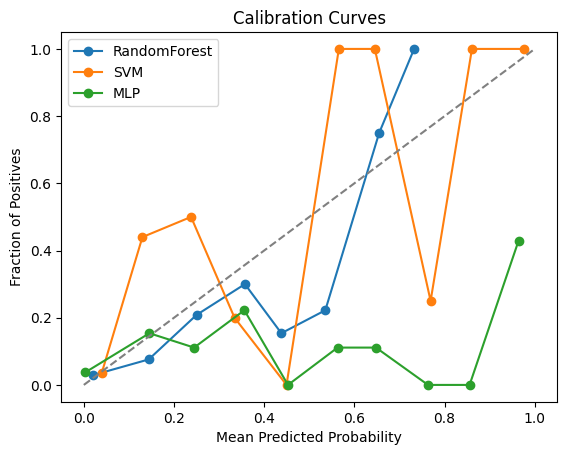

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

# Drop rows with missing target
df = df.dropna(subset=["dementia"])

X = df.drop("dementia", axis=1)
y = df["dementia"].values.astype(int)

num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_features = ["gender", "diabetes", "smoking", "hypertension", "hypercholesterolemia"]

# ======================================
# STEP 2: Helper Functions
# ======================================
def compute_ci(scores):
    """Return mean and 95% CI."""
    mean = np.mean(scores)
    se = np.std(scores, ddof=1) / np.sqrt(len(scores))
    ci = 1.96 * se
    return mean, (mean - ci, mean + ci)

def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []
oof_preds = {name: np.zeros(len(y)) for name in ml_models.keys()}
oof_probas = {name: np.zeros(len(y)) for name in ml_models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    imputer = SimpleImputer(strategy="mean")  # numeric imputation
    scaler = StandardScaler()

    X_train_num = imputer.fit_transform(X_train[num_features])
    X_test_num = imputer.transform(X_test[num_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    # Encode categoricals
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0]))
    X_test_cat  = ohe.transform(X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0]))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_cat])
    X_test_f  = np.hstack([X_test_num, X_test_cat])

    for name, model in ml_models.items():
        model.fit(X_train_f, y_train)
        y_pred = model.predict(X_test_f)
        y_proba = model.predict_proba(X_test_f)[:,1]

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        results_ml.append([name, fold, acc, auc, pr_auc])
        oof_preds[name][test_idx] = y_pred
        oof_probas[name][test_idx] = y_proba

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC"])

summary_ml = results_ml.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x))
)

print("=== ML Models Performance (mean ± 95% CI) ===")
for model, row in summary_ml.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y)), "CNN+Transformer": np.zeros(len(y))}
oof_probas_dl = {"HNN": np.zeros(len(y)), "CNN+Transformer": np.zeros(len(y))}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling ===
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()

    X_train_num = imputer.fit_transform(X_train[num_features])
    X_test_num = imputer.transform(X_test[num_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0]))
    X_test_cat  = ohe.transform(X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0]))

    X_train_f = np.hstack([X_train_num, X_train_cat])
    X_test_f  = np.hstack([X_test_num, X_test_cat])

    y_train_np, y_test_np = np.array(y_train), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f).ravel()
    y_pred = (y_proba>0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    results_dl.append(["HNN", fold, acc, auc, pr_auc])
    oof_preds_dl["HNN"][test_idx] = y_pred
    oof_probas_dl["HNN"][test_idx] = y_proba

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1)).ravel()
    y_pred = (y_proba>0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    results_dl.append(["CNN+Transformer", fold, acc, auc, pr_auc])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred
    oof_probas_dl["CNN+Transformer"][test_idx] = y_proba

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC"])

summary_dl = results_dl.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x))
)

print("=== DL Models Performance (mean ± 95% CI) ===")
for model, row in summary_dl.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")

# ======================================
# STEP 5: Calibration & Brier Score
# ======================================
calibration_results = []

for name in ml_models.keys():
    brier = brier_score_loss(y, oof_probas[name])
    calibration_results.append([name, brier])

for name in oof_preds_dl.keys():
    brier = brier_score_loss(y, oof_probas_dl[name])
    calibration_results.append([name, brier])

calibration_results = pd.DataFrame(calibration_results, columns=["Model","BrierScore"])
print("\n=== Brier Scores ===")
print(calibration_results)

# Calibration plots for selected models
for name in ["RandomForest","SVM","MLP"]:
    prob_true, prob_pred = calibration_curve(y, oof_probas[name], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.title("Calibration Curves")
plt.show()
